<a href="https://colab.research.google.com/github/vishalrk1/tensorflow_course/blob/main/TransferLeanring_and_Finetunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer learning : Fine tunning

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential

## Importing helper functions script

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-05 13:48:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-05 13:48:19 (57.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# importing helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, pred_and_plot, unzip_data, walk_through_dir

###Downloading and unzipping Data

In [ ]:
# importing 10% data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data(filename='10_food_classes_10_percent.zip')

--2021-10-05 13:48:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  48.3MB/s    in 3.3s    

2021-10-05 13:48:23 (48.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



###Checking how many images and subcategories are there in data set

In [ ]:
walk_through_dir(dir_path='10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

###Data Agumentation using image_dataset_from_directory

In [ ]:
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE= 32

print('Training Data')
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
)

print('Test Data')
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
)

Training Data
Found 750 files belonging to 10 classes.
Test Data
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

##Bulding a transfer learning model using keras functional api

In [ ]:
# creating base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False,)

# Freezing the base model ( so that pre-trained model aren't update)
base_model.trainable = False

# creating inputs into model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# using resnet50V2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# pass the input to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# Average pooling the outeputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avrage_pooling_layer')(x)
print(f"Shape after GlobalAveragepooling: {x.shape}")

# Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# combining the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 1s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragepooling: (None, 1280)


In [ ]:
# compiling model
model_0.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy']
)

# fitting the model
history_0 = model_0.fit(
    train_data_10_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data,
    validation_steps = 0.25 * len(test_data),
    callbacks = [create_tensorboard_callback(dir_name='transfer_learning', experiment_name='10_percent_model_0')]
)

Saving TensorBoard log files to: transfer_learning/10_percent_model_0/20211005-134836
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 44s 373ms/step - loss: 1.9350 - accuracy: 0.3733 - val_loss: 1.3971 - val_accuracy: 0.6484
Epoch 2/5
24/24 [==============================] - 7s 263ms/step - loss: 1.1617 - accuracy: 0.7467 - val_loss: 0.9544 - val_accuracy: 0.7547
Epoch 3/5
24/24 [==============================] - 9s 352ms/step - loss: 0.8447 - accuracy: 0.8013 - val_loss: 0.7629 - val_accuracy: 0.8047
Epoch 4/5
24/24 [==============================] - 9s 352ms/step - loss: 0.6799 - accuracy: 0.8627 - val_loss: 0.7069 - val_accuracy: 0.8016
Epoch 5/5
24/24 [==============================] - 7s 261ms/step - loss: 0.5825 - accuracy: 0.8733 - val_loss: 0.6309 - val_accuracy: 0.8219


In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 11s 133ms/step - loss: 0.6064 - accuracy: 0.8420


[0.6063862442970276, 0.8420000076293945]

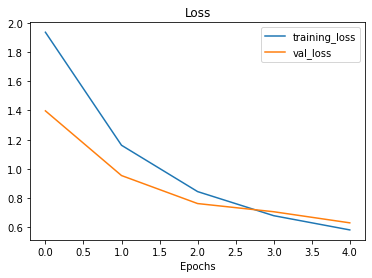

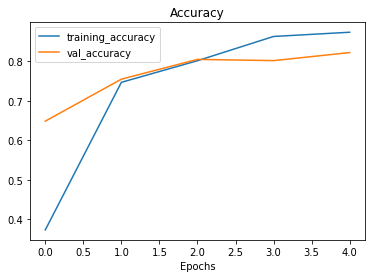

In [ ]:
plot_loss_curves(history_0)

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avrage_pooling_layer  (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


###Feature vector of model

* Using tensor shape od (1, 4, 4, 4) and passing it through GlobalAveragePooling2D to what result we get

In [ ]:
input_shape = (1, 4, 4, 3)

# random tensor
tf.random.set_seed(42)
random_tensor = tf.random.normal(input_shape)

# passing random tensor throught GlobalAveragePooling2D
X = tf.keras.layers.GlobalAveragePooling2D()(random_tensor)
print(f"Output shape: {X.shape}")
print(f"Output: {X}")

Output shape: (1, 3)
Output: [[-0.09368646 -0.45840448 -0.2885598 ]]


##Transfer Learning Experiment

###Model_1

* using 1% data of training Data with data agumentation

####Preprocessing Data for model_1

In [ ]:
# Downloading and unziping 1% data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data(filename='10_food_classes_1_percent.zip')

--2021-10-05 13:50:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   102MB/s    in 1.3s    

2021-10-05 13:50:08 (102 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# training and test directories
train_dir = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [ ]:
walk_through_dir(dir_path='10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'

In [ ]:
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                           label_mode = 'categorical',
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           label_mode = 'categorical',
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


####Adding Data Augmentation into the model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# data augmentation stage with horizontal flipping, rotation, zooms, etc....
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255)
], name='data_augmentation')

####Feature Extraction

In [ ]:
# input shape for base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Creating input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# adding data augmentation sequential layer
x = data_augmentation(inputs)

# passing inputs throug base model
x = base_model(x, training=False)

# pooling outputs of base model
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# dense layer
output = Dense(10, activation='softmax', name='output_layer')(x)

# creat model
model_1 = keras.Model(inputs, output)

model_1.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy']
)

history_1 = model_1.fit(
    train_data_1_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_1_percent),
    validation_data = test_data_1_percent,
    validation_steps = 0.25 * len(test_data_1_percent),
    callbacks = [create_tensorboard_callback('transfer_learning','model_1')]
)

Saving TensorBoard log files to: transfer_learning/model_1/20211005-135013
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 15s 3s/step - loss: 2.4496 - accuracy: 0.0857 - val_loss: 2.2397 - val_accuracy: 0.1781
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1242 - accuracy: 0.2714 - val_loss: 2.1179 - val_accuracy: 0.2438
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9966 - accuracy: 0.4000 - val_loss: 2.0007 - val_accuracy: 0.3562
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 1.8166 - accuracy: 0.5571 - val_loss: 1.9264 - val_accuracy: 0.3844
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.6348 - accuracy: 0.6000 - val_loss: 1.8464 - val_accuracy: 0.4219


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
model_1.evaluate(test_data_1_percent)

79/79 [==============================] - 11s 128ms/step - loss: 1.8521 - accuracy: 0.4184


[1.8520601987838745, 0.41839998960494995]

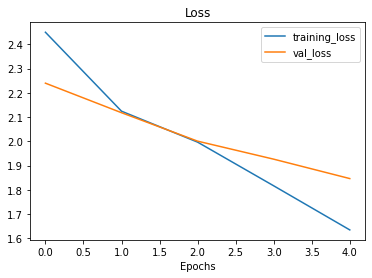

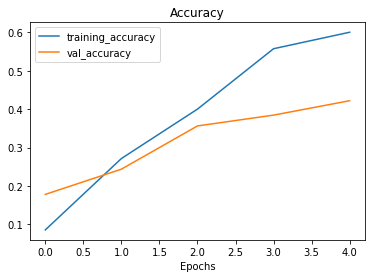

In [ ]:
plot_loss_curves(history_1)

###Model_2

* **using 10 percent of food 101 data**

####Preprocessing data for model_2

In [ ]:
train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir_10_percent = '10_food_classes_10_percent/test'

In [ ]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = 'categorical',
                                                                            image_size = IMG_SIZE)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10_percent,
                                                                            label_mode = 'categorical',
                                                                            image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


* **Data augmentation model**

In [ ]:
from tensorflow import  keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


# data agumentation layer
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name = 'data_aguentation')

# input_shape
input_shape = (224, 224, 3)

# base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False,

# input layer
input_layer = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_poolin_2D')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs)

# compiling model
model_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy'],
)


In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_aguentation (Sequential (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_poolin_2D (Gl (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 4,020,358
Non-trainable params: 42,023
_________________________________________________________________


####**Model Checkpointing callbacks**

In [ ]:
# setting path
checkpoint_path = '10_percent_model_2_checkpoints_weights/checkpoint.ckpt'

# creating callback which saves weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only = True,
    save_best_only = False,
    save_freq = 'epoch',
    verbose = 1
)

In [ ]:
history_2 = model_2.fit(
    train_data_10_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data_10_percent,
    validation_steps = 0.25 * len(test_data_10_percent),
    callbacks = [
                 checkpoint_callback,
                 create_tensorboard_callback('transfer_learning','10_percent_data_model_2')
    ],
)

Saving TensorBoard log files to: transfer_learning/10_percent_data_model_2/20211005-135119
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 56s 2s/step - loss: 2.2484 - accuracy: 0.2360 - val_loss: 1.8047 - val_accuracy: 0.3766

Epoch 00001: saving model to 10_percent_model_2_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 38s 2s/step - loss: 1.4686 - accuracy: 0.4987 - val_loss: 1.3738 - val_accuracy: 0.5234

Epoch 00002: saving model to 10_percent_model_2_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 36s 1s/step - loss: 1.1125 - accuracy: 0.6253 - val_loss: 0.8749 - val_accuracy: 0.6938

Epoch 00003: saving model to 10_percent_model_2_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 31s 1s/step - loss: 0.8401 - accuracy: 0.7307 - val_loss: 1.7151 - val_accuracy: 0.5641

Epoch 00004: saving model to 10_percent_model_2_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 34s 1s/step - loss: 0.7425 - accuracy: 0.7573 - val_loss: 0.748

In [ ]:
model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 11s 128ms/step - loss: 0.8737 - accuracy: 0.7232


[0.8737401366233826, 0.7232000231742859]

In [ ]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 11s 127ms/step - loss: 0.6064 - accuracy: 0.8420


[0.6063861846923828, 0.8420000076293945]

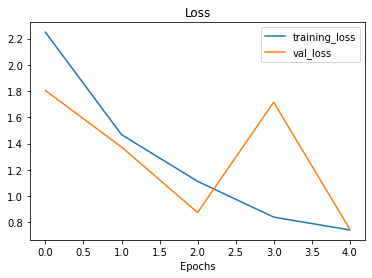

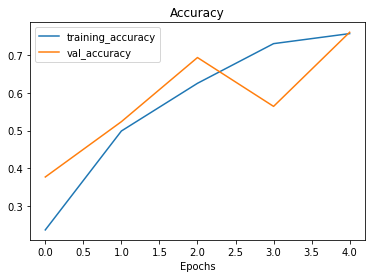

In [ ]:
plot_loss_curves(history_2)

###Model_3 & fine tunning

In [ ]:
print(len(model_2.layers[2].trainable_variables))

211


In [ ]:
# setting last 10 layers of base model trainable

base_model.trainable = True

# freezing all layers except last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# recompiling model
model_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=0.0001),
    metrics = ['accuracy']
)

In [ ]:
print(len(model_2.layers[2].trainable_variables))

10


In [ ]:
initial_epoch = 5

In [ ]:
# fine tune anothe 5 epoch 
final_tune_epoch = initial_epoch + 5

history_fine_10_percent_data_aug = model_2.fit(
    train_data_10_percent,
    epochs = final_tune_epoch,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data_10_percent,
    validation_steps = 0.25 * len(test_data_10_percent),
    initial_epoch = history_2.epoch[-1],
    callbacks = [
                 checkpoint_callback,
                 create_tensorboard_callback('transfer_learning','10_percent_data_fine_tune')
    ],
)

Saving TensorBoard log files to: transfer_learning/10_percent_data_fine_tune/20211005-135550
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 22s 621ms/step - loss: 0.3662 - accuracy: 0.8867 - val_loss: 0.6802 - val_accuracy: 0.7984

Epoch 00005: saving model to 10_percent_model_2_checkpoints_weights/checkpoint.ckpt
Epoch 6/10
24/24 [==============================] - 15s 608ms/step - loss: 0.2691 - accuracy: 0.9160 - val_loss: 0.6636 - val_accuracy: 0.8000

Epoch 00006: saving model to 10_percent_model_2_checkpoints_weights/checkpoint.ckpt
Epoch 7/10
24/24 [==============================] - 12s 488ms/step - loss: 0.2442 - accuracy: 0.9253 - val_loss: 0.6537 - val_accuracy: 0.8125

Epoch 00007: saving model to 10_percent_model_2_checkpoints_weights/checkpoint.ckpt
Epoch 8/10
24/24 [==============================] - 15s 603ms/step - loss: 0.2305 - accuracy: 0.9360 - val_loss: 0.6611 - val_accuracy: 0.8094

Epoch 00008: saving model to 10_percent_model_2_checkpoints_weights/checkpoint.ckpt
Epoch 9/10
24/24 [==============================] - 14s 595ms/step - loss: 0.1734 - accuracy: 0.954

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 11s 127ms/step - loss: 0.7060 - accuracy: 0.8032


[0.7059744000434875, 0.8032000064849854]

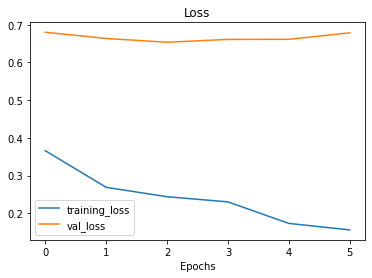

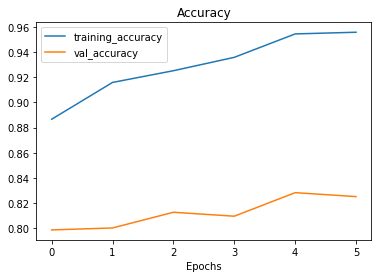

In [ ]:
plot_loss_curves(history_fine_10_percent_data_aug )

In [ ]:
from helper_functions import compare_historys

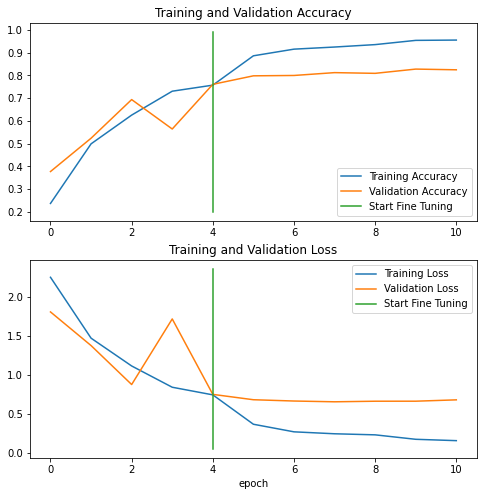

In [ ]:
compare_historys(history_2, history_fine_10_percent_data_aug)

###Model_4: Fine tunning on more Data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data('10_food_classes_all_data.zip')

--2021-10-05 14:10:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  65.3MB/s    in 8.0s    

2021-10-05 14:10:49 (62.2 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# setting up train and test directories
train_dir = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

In [ ]:
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 

In [ ]:
# setting up data
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_all_10_food = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size = BATCH_SIZE,
    label_mode='categorical'
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size = BATCH_SIZE,
    label_mode='categorical'
)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 11s 128ms/step - loss: 0.7060 - accuracy: 0.8032


[0.7059743404388428, 0.8032000064849854]

In [ ]:
from tensorflow import  keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


# data agumentation layer
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name = 'data_aguentation')

# input_shape
input_shape = (224, 224, 3)

# base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False,

# input layer
input_layer = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_poolin_2D')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

model = tf.keras.Model(inputs, outputs)

# compiling model
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy'],
)

initial_epoch = 5

history_3 = model.fit(
    train_data_10_percent,
    epochs = initial_epoch,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data_10_percent,
    validation_steps = 0.25 * len(test_data_10_percent),
    callbacks = [
                 checkpoint_callback,
                 create_tensorboard_callback('transfer_learning','10_percent_data_model_2')
    ],
)

Saving TensorBoard log files to: transfer_learning/10_percent_data_model_2/20211005-142020
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 45s 1s/step - loss: 2.3394 - accuracy: 0.1120 - val_loss: 2.2994 - val_accuracy: 0.1406

Epoch 00001: saving model to 10_percent_model_2_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 27s 1s/step - loss: 2.3599 - accuracy: 0.0973 - val_loss: 2.3246 - val_accuracy: 0.0828

Epoch 00002: saving model to 10_percent_model_2_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 29s 1s/step - loss: 2.3208 - accuracy: 0.0920 - val_loss: 2.3133 - val_accuracy: 0.0891

Epoch 00003: saving model to 10_percent_model_2_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 28s 1s/step - loss: 2.3039 - accuracy: 0.1053 - val_loss: 2.3012 - val_accuracy: 0.1094

Epoch 00004: saving model to 10_percent_model_2_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 30s 1s/step - loss: 2.3209 - accuracy: 0.1040 - val_loss: 2.301